In [1]:
import umap
from sklearn.datasets import load_digits
import os
import glob
import numpy as np
import nibabel as nii
import math
import operator
#import patch_extraction
from scipy.ndimage.interpolation import zoom
from keras.models import load_model
from scipy import ndimage
import scipy.io as sio
import matplotlib.pyplot as plt
import modelos

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: F

In [4]:
model=modelos.load_UNET3D_SLANT27_v2_groupNorm(96,96,96,2,1,24,0.5,final_act='sigmoid')
model.compile(optimizer='adam', loss='mse')

In [44]:
listaT1 = sorted(glob.glob("../lib/volbrain_qc/n_mfmni*t1*.nii*"))
listaFLAIR = sorted(glob.glob("../lib/volbrain_qc/n_mfmni*flair*.nii*"))
#listaLAB = sorted(glob.glob("../lib/volbrain_qc/DLB*lesion*.nii*"))
listaMASK = sorted(glob.glob("../lib/volbrain_qc/mask*.nii*"))

In [45]:
listaT1_isbi = sorted(glob.glob("../lib/isbi_final_train_preprocessed/training*mprage*.nii*"))
listaFLAIR_isbi = sorted(glob.glob("../lib/isbi_final_train_preprocessed/training*flair*.nii*"))

In [7]:
#listaT1_isbi

In [8]:
import statsmodels.api as sm
from scipy.signal import argrelextrema
from collections import OrderedDict, defaultdict
from skimage import measure
from scipy.stats import pearsonr

def normalize_image(vol, contrast):
    # copied from FLEXCONN
    # slightly changed to fit our implementation
    temp = vol[np.nonzero(vol)].astype(float)
    q = np.percentile(temp, 99)
    temp = temp[temp <= q]
    temp = temp.reshape(-1, 1)
    bw = q / 80
    # print("99th quantile is %.4f, gridsize = %.4f" % (q, bw))

    kde = sm.nonparametric.KDEUnivariate(temp)

    kde.fit(kernel='gau', bw=bw, gridsize=80, fft=True)
    x_mat = 100.0 * kde.density
    y_mat = kde.support

    indx = argrelextrema(x_mat, np.greater)
    indx = np.asarray(indx, dtype=int)
    heights = x_mat[indx][0]
    peaks = y_mat[indx][0]
    peak = 0.00
    # print("%d peaks found." % (len(peaks)))

    # norm_vol = vol
    if contrast.lower() in ["t1", "mprage"]:
        peak = peaks[-1]
        # print("Peak found at %.4f for %s" % (peak, contrast))
        # norm_vol = vol/peak
        # norm_vol[norm_vol > 1.25] = 1.25
        # norm_vol = norm_vol/1.25
    elif contrast.lower() in ['t2', 'pd', 'flair', 'fl']:
        peak_height = np.amax(heights)
        idx = np.where(heights == peak_height)
        peak = peaks[idx]
        # print("Peak found at %.4f for %s" % (peak, contrast))
        # norm_vol = vol / peak
        # norm_vol[norm_vol > 3.5] = 3.5
        # norm_vol = norm_vol / 3.5
    else:
        print("Contrast must be either t1,t2,pd, or flair. You entered %s. Returning 0." % contrast)

    # return peak, norm_vol
    return peak

def load_modalities(T1_name,FLAIR_name,MASK_name=None):
    T1_img = nii.load(T1_name)
    T1=T1_img.get_data()
    T1=T1.astype('float32')
    FLAIR_img = nii.load(FLAIR_name)
    FLAIR=FLAIR_img.get_data()
    FLAIR=FLAIR.astype('float32')
    if(not MASK_name==None):
        MASK_img = nii.load(MASK_name)
        MASK = MASK_img.get_data()
        MASK=MASK.astype('int')
        T1=T1*MASK
        FLAIR=FLAIR*MASK
    peak = normalize_image(T1, 't1')
    T1=T1/peak
    peak = normalize_image(FLAIR, 'flair')
    FLAIR=FLAIR/peak
    return T1,FLAIR

def crop_center(img,cropx,cropy,cropz):
    x,y,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    startz = z//2-(cropz//2)
    return img[starty:starty+cropy,startx:startx+cropx,startz:startz+cropz]

def to969696(T1,FLAIR):
    T1=crop_center(T1,96,96,96)
    FLAIR=crop_center(FLAIR,96,96,96)
    return T1,FLAIR
    

In [9]:
#T1,FLAIR=load_modalities(listaT1[0],listaFLAIR[0],listaMASK[0])

In [10]:
#T1_cropped,FLAIR_cropped=to969696(T1,FLAIR)

In [11]:
#x_in=np.concatenate((np.expand_dims(T1_cropped,axis=3),np.expand_dims(FLAIR_cropped,axis=3)), axis=3)
#x_in=np.expand_dims(x_in,axis=0)

In [12]:
from keras import backend as K

input1 = model.input               # input placeholder

output1 = model.get_layer('bottleneck').output# all layer outputs

fun = K.function([input1, K.learning_phase()],[output1])# evaluation function



In [13]:
#bottleneck_out = fun([x_in, 1.])
#model.predict(x_in)

In [14]:
#bottleneck_out[0].mean(axis=(0,1,2,3)).shape

In [15]:
#bottleneck_features={}
#bottleneck_features[listaT1[0]]=bottleneck_out[0].mean(axis=(0,1,2,3))

In [16]:
#bottleneck_features

In [17]:
#####ON ISBI#####

In [42]:
#bottleneck_features=np.empty((1,384))
file_names=[]

In [43]:
for i in range(len(listaT1_isbi)):
    T1,FLAIR=load_modalities(listaT1_isbi[i],listaFLAIR_isbi[i])
    T1_cropped,FLAIR_cropped=to969696(T1,FLAIR)
    x_in=np.concatenate((np.expand_dims(T1_cropped,axis=3),np.expand_dims(FLAIR_cropped,axis=3)), axis=3)
    x_in=np.expand_dims(x_in,axis=0)
    #bottleneck_features[listaT1_isbi[i]]=bottleneck_out[0].mean(axis=(0,1,2,3))
    bottleneck_out = fun([x_in, 1.])
    if(i==0):
        bottleneck_features=np.expand_dims(bottleneck_out[0].mean(axis=(0,1,2,3)),axis=0)
    else:
        bottleneck_features=np.concatenate((bottleneck_features,np.expand_dims(bottleneck_out[0].mean(axis=(0,1,2,3)),axis=0)),axis=0)
    file_names.append(listaT1_isbi[i])
    

In [44]:
#np.array(listaT1_isbi[i]).shape

In [45]:
#####ON VOLBRAIN#####

In [46]:
for i in range(len(listaT1)):
    #if(i==100):
    #    break
    T1,FLAIR=load_modalities(listaT1[i],listaFLAIR[i])
    T1_cropped,FLAIR_cropped=to969696(T1,FLAIR)
    x_in=np.concatenate((np.expand_dims(T1_cropped,axis=3),np.expand_dims(FLAIR_cropped,axis=3)), axis=3)
    x_in=np.expand_dims(x_in,axis=0)
    bottleneck_out = fun([x_in, 1.])
    #bottleneck_features[listaT1[i]]=bottleneck_out[0].mean(axis=(0,1,2,3))
    bottleneck_features=np.concatenate((bottleneck_features,np.expand_dims(bottleneck_out[0].mean(axis=(0,1,2,3)),axis=0)),axis=0)
    file_names.append(listaT1[i])

In [23]:
#bottleneck_features=bottleneck_features.reshape((1,-1))

In [54]:
np.save('bottleneck_features.h5',bottleneck_features)
np.save('file_names.h5',file_names)

In [24]:
#####UMAP######

In [25]:
bottleneck_features.shape

(121, 384)

In [26]:
len(file_names)

121

In [27]:
#bottleneck_features=bottleneck_features[1:]
#np.where(np.abs(bottleneck_features)< 1e-7)
#bottleneck_features[0]

In [39]:

import time,umap
#import numpy as np

start = time.time()
#reducer = umap.UMAP(n_neighbors=2000,min_dist=1).fit(alldata)
reducer = umap.UMAP().fit(bottleneck_features)
#reducer = umap.UMAP().fit(np.ones((100,10)))

end = time.time()
print(end - start)

11.093610525131226


In [40]:
import matplotlib


In [38]:
#labels.embedding_.shape

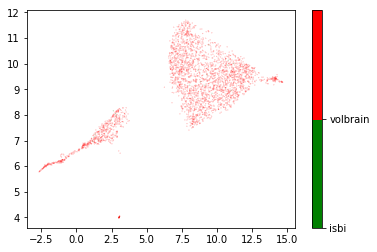

In [46]:
labels=np.concatenate((  np.ones(len(listaT1_isbi))*0 ,  np.ones(len(listaT1)) ))
#labels=np.concatenate((  np.ones(len(listaT1_isbi))*0 ,  np.ones(100) ))
vis=np.concatenate((reducer.embedding_,labels.reshape((-1,1))),axis=1)
red_vis=vis
tick = ['Labeled','pseudo-Labeled','Unlabeled']
colors = ['green','blue','red']

plt.scatter(   red_vis [:,0], red_vis [:,1], s=0.01,c=red_vis [:,2].astype(int), cmap=matplotlib.colors.ListedColormap(colors))
#plt.colorbar()


cb = plt.colorbar()
loc = np.arange(0,max(red_vis [:,2].astype(int)),max(red_vis [:,2].astype(int))/float(len(tick)))
cb.set_ticks(loc)
cb.set_ticklabels(tick)
#plt.savefig('plot_100firstof volbrain.eps', format='eps')
plt.savefig('plot_volbrain.eps', format='eps')

In [2]:
bottleneck_features=np.load('bottleneck_features.h5.npy')
file_names=np.load('file_names.h5.npy')

In [133]:
#file_names[:21]

In [3]:
Q = bottleneck_features[:21].T
X = bottleneck_features[21:].T


In [77]:

K = 100 # approx 50 mutual nns
QUERYKNN = 21#10
R = 2000
alpha = 0.9
from diffussion import *
import time
start = time.time()

sim  = np.dot(X.T, Q)
#""""
qsim = sim_kernel(sim).T

sortidxs = np.argsort(-qsim, axis = 1)
for i in range(len(qsim)):
    qsim[i,sortidxs[i,QUERYKNN:]] = 0
#"""
qsim = sim_kernel(qsim)
A = np.dot(X.T, X)
W = sim_kernel(A).T
W = topK_W(W, K)
Wn = normalize_connection_graph(W)

#plain_ranks = np.argsort(-sim, axis=0)
cg_ranks =  cg_diffusion(qsim, Wn, alpha)
#cg_trunk_ranks =  dfs_trunk(sim, A, alpha = alpha, QUERYKNN = QUERYKNN )
#fast_spectral_ranks = fsr_rankR(qsim, Wn, alpha, R)

end = time.time()
print(end - start)

1.1200342178344727


/data1/rkamraoui/DeepvolBrain/Segmentation/DeepLesionBrain/SSL/diffussion.py:16: RuntimeWarning: divide by zero encountered in true_divide
  D = np.array(1./ np.sqrt(W.sum(axis = 1)))


In [80]:
"""
cg_ranks[:,15].argmin()
cg_ranks[:,15].argmax()
order=fast_spectral_ranks.mean(axis=1)
reducer.embedding_[2900+21]
reducer.embedding_[15]
order.argmin()
order[2896]
order.argmax()
"""

57

In [104]:
volbrain_useful=[]

In [119]:
def give_n_closest(ranks,n_indxs=100):
    indxs=[]
    querries_num=ranks.shape[1]
    #datapoints_num=ranks.shape[0]
    for j in range(n_indxs//querries_num +1 ):
        for i in range(querries_num):
            indx=ranks[:,i].argmin()
            #indx=ranks[:,i].argmax()
            indxs.append(indx)
            ranks[indx,:]=9999
            #ranks[indx,:]=0
    return indxs
    
    

In [120]:
indxs= give_n_closest(cg_ranks)

In [110]:
volbrain_useful.append(file_names[np.array(indxs)+21].tolist)

In [111]:
len(volbrain_useful)

2

In [109]:
file_names[np.array(indxs)+21].shape

()

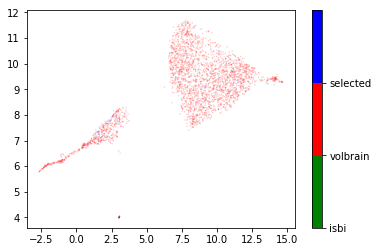

In [132]:
labels=np.concatenate((  np.ones(len(listaT1_isbi))*0 ,  np.ones(len(listaT1)) ))

labels[np.array(indxs)+21]= 3

vis=np.concatenate((reducer.embedding_,labels.reshape((-1,1))),axis=1)
red_vis=vis
tick = ['isbi','volbrain','selected']
colors = ['green','red','blue']

plt.scatter(   red_vis [:,0], red_vis [:,1], s=0.01,c=red_vis [:,2].astype(int), cmap=matplotlib.colors.ListedColormap(colors))
#plt.colorbar()


cb = plt.colorbar()
loc = np.arange(0,max(red_vis [:,2].astype(int)),max(red_vis [:,2].astype(int))/float(len(tick)))
cb.set_ticks(loc)
cb.set_ticklabels(tick)
#plt.savefig('plot_100firstof volbrain.eps', format='eps')
plt.savefig('plot_volbrain_selected.eps', format='eps')

In [126]:
def distance_measure(x1,x2):
    return np.sum((x1-x2)**2)
    

In [122]:
res_dis=np.zeros((len(file_names)-21,21))

In [128]:
for i in range(21):
    print(i)
    for j in range(len(file_names)-21):
        res_dis[j,i]=distance_measure(X[:,j],Q[:,i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [147]:
res_dis.shape()

TypeError: 'tuple' object is not callable

In [131]:
indxs=give_n_closest(res_dis)

In [136]:
a=[1,2,3]
b=[1,2,3,4,5,6]
c= [x for x in b if x not in a]

In [142]:
[b[i] for i in a]

[2, 3, 4]

In [145]:
len(np.array(b)[a])

3

In [162]:
a=np.random.normal(0.3,5,(5,5))

In [163]:
np.unravel_index(np.argmin(a, axis=None), a.shape)

(3, 1)

In [161]:
a

array([[-0.87627272,  3.88418747,  5.84506465,  6.63775387, -0.25148922],
       [-0.91750974, -3.97599008, -4.36702408,  0.07540367, -0.93675444],
       [ 3.20354219, -3.7496331 ,  1.45370029,  3.46278937,  3.95732728],
       [-1.84498267,  5.09058817, -1.3889049 , -4.1051377 , -3.48948357],
       [-3.85600186,  8.55356074,  3.07880517,  1.89617356, -6.84425297]])